In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
from sklearn.preprocessing import StandardScaler

In [4]:
def jump(mu0, sigma0, n0, mu1, sigma1, n1):
    
    X0 = np.random.normal(mu0, sigma0, n0).reshape(-1, 1)
    X1 = np.random.normal(mu1, sigma1, n1).reshape(-1, 1)
    
    X = np.concatenate((X0, X1), axis=0)
    T = np.arange(len(X))
    L = np.array([0]*n0 + [1]*n1)
    
    return T, X, L

In [5]:
mu0=0
sigma0=1
n0=200

mu1=1.
sigma1=1
n1=200

T, X, L = jump(mu0, sigma0, n0, mu1, sigma1, n1) 

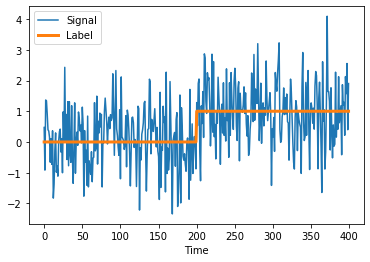

In [6]:
plt.plot(T, X, label='Signal')
plt.plot(T, L, label='Label', linewidth=3)
plt.xlabel('Time')
plt.legend()
plt.show() 

In [7]:
import torch 

In [8]:
ss = StandardScaler()
X2 = ss.fit_transform(X)

In [9]:
%%time

from klcpd import KL_CPD

device = torch.device('cpu')
window_size = 50
model = KL_CPD(X.shape[1], p_wnd_dim=window_size, f_wnd_dim=window_size).to(device)
model.fit(X2, epoches=1)

preds = model.predict(X2)

CPU times: user 25.2 s, sys: 9.5 s, total: 34.7 s
Wall time: 14.2 s


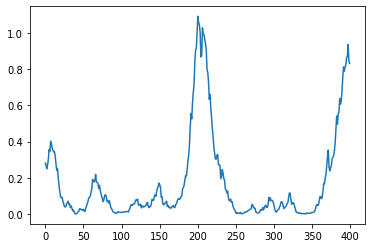

In [10]:
plt.plot(preds)

In [11]:
from abc import ABCMeta, abstractmethod
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
import sys
sys.path.append('../scripts')
import metrics

from joblib import Parallel, delayed


def run_experiments(algo_class, algo_params, thresholds, n_iters, mu_steps):
    curves_mean = []
    curves_std = []

    for mu1 in mu_steps:
        data_args = {
            "mu0": 0,
            "sigma0": 1,
            "n0": 300,
            "mu1": mu1,
            "sigma1": 1, 
            "n1": 100
        }
        
        args = (algo_class, algo_params, thresholds, data_args)
        curves = Parallel(n_jobs=-1)(delayed(run_and_estimate)(*args) for _ in range(n_iters))
        curve_mean = np.mean(curves, axis=0)
        curve_std = np.std(curves, axis=0) / np.sqrt(n_iters)

        curves_mean.append(curve_mean)
        curves_std.append(curve_std)
    
    return curves_mean, curves_mean    



def run_and_estimate(algo_class, algo_params, thresholds, data_args, cut=True):
    algorithm = algo_class(**algo_params)
    _, X, L = jump(**data_args)

    scores = algorithm.run(X)
    qm = metrics.OnlineQualityMetrics(thresholds)
    if cut:
        cut_size = algo_params["cut_size"]
        scores = scores[cut_size:]
        L = L[cut_size:]
    acurve = qm.estimate(scores, L) 
    return acurve


class KlCpdAlgo:
    def __init__(self, *args, **kwargs):
        self.window_size = kwargs["window_size"]
        self.device = kwargs["device"]
        self.epoches = kwargs["epoches"]
        self.label = kwargs["label"]
        
        self.cut_size = kwargs["cut_size"]
    
    def run(self, X):
        from klcpd import KL_CPD
        
        ss = StandardScaler()
        X2 = ss.fit_transform(X)
        
        device = torch.device(self.device)
        window_size = self.window_size
        model = KL_CPD(X.shape[1], p_wnd_dim=window_size, f_wnd_dim=window_size).to(device)
        model.fit(X2, epoches=self.epoches)
        
        preds = model.predict(X2)
        
        scores = preds.copy()
        scores[:window_size] = 0
        scores = np.concatenate((np.zeros(window_size), scores[:-window_size]))
        
        return scores

In [12]:
mu_steps = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.25, 1.5, 1.75, 2]

In [14]:
%%time 

n_iters = 1
thresholds = np.linspace(0, 1, 1001)

kl_cpd_params = {
    "window_size": 50, 
    "device": "cpu", 
    "epoches": 1, 
    "label": "KL-CPD score",
    "cut_size": 50
}

kl_cpd_mean, kl_cpd_std = run_experiments(KlCpdAlgo, kl_cpd_params, thresholds, n_iters, mu_steps)

CPU times: user 135 ms, sys: 82.9 ms, total: 218 ms
Wall time: 5min 17s


In [ ]:
kl_cpd_algo.plots(kl_cpd_mean, kl_cpd_std, mu_steps)